# (Bio)Schema(.org) experiments

The objective of this notebook is to "demo" : 
 1. what are Schema.org semantic annotations and how they can be written in Turtle and JSON-LD
 3. how Bio.Tools entries can be programmatically `translated` into Schema.org annotations
 
 To be executable, this notebook should be run in a conda environment : 
 ```
 conda install rdflib-jsonld urllib3 jupyter networkx matplotlib -c bioconda -c conda-forge
 pip install nxpd
 ```
 
 For any related question, please contact [alban.gaignard@univ-nantes.fr](mailto:alban.gaignard@univ-nantes.fr)

In [1]:
from IPython.display import display, Markdown, Latex
from rdflib import Graph, RDF, RDFS, Namespace
import networkx as nx
from nxpd import draw

context = "http://schema.org/"

## 1. How to represent Schema.org metadata
This cell shows how to use the [schema.org](https://schema.org) vocabulary to represent basic statements (as RDF triples : *subject*, *predicate*, *object*). We use the [Turtle](https://www.w3.org/TR/turtle/) RDF syntax. 

The `rsat` variable contains a very basic RDF graph with the following statements: *RSAT_Retrieve_Sequence is a Software application* and *RSAT_Retrieve_Sequence has for application category "Bioinformatics"* 

Schema.org has been designed to provide general semantics to web page. It is generally embedded as JSON objects, folllowing the [JSON-LD](https://json-ld.org/playground/) convention. However, manually writing JSON-LD can be teddious.   

In [2]:
rsat = '''
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sco: <http://schema.org/> .

<https://bio.tools/RSAT_-_Retrieve_Sequence> rdf:type sco:SoftwareApplication .
<https://bio.tools/RSAT_-_Retrieve_Sequence> sco:applicationCategory "Bioinformatics" .
'''

mcrossbase = '''
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sco: <http://schema.org/> .

<http://hfaistos.uio.no:8002> rdf:type sco:SoftwareApplication ;
        sco:applicationCategory "RNA binding" ;
        sco:citation "Feng et al. (2018), Modeling the in vivo specificity of RNA-binding proteins by precisely registering protein-RNA crosslink sites. in submission." .
'''

#Parsing and loading of this graph with RDFlib 
g = Graph().parse(data=rsat, format='turtle')

display(Markdown('**Serialization of this graph in the** `TURTLE` syntax:'))
print(g.serialize(format='turtle', indent=4).decode('utf-8'))

display(Markdown('**Serialization of the same graph in the** `JSON-LD` syntax:'))
print(g.serialize(format='json-ld', context=context, indent=4).decode('utf-8'))

**Serialization of this graph in the** `TURTLE` syntax:

@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sco: <http://schema.org/> .
@prefix xml: <http://www.w3.org/XML/1998/namespace> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<https://bio.tools/RSAT_-_Retrieve_Sequence> a sco:SoftwareApplication ;
    sco:applicationCategory "Bioinformatics" .




**Serialization of the same graph in the** `JSON-LD` syntax:

{
    "@context": "http://schema.org/",
    "http://schema.org/applicationCategory": "Bioinformatics",
    "id": "https://bio.tools/RSAT_-_Retrieve_Sequence",
    "type": "SoftwareApplication"
}


# Why these statements form a graph ? 
RDF graphs are constituted with a collection of triples `(S, P, O)` where `S` is the source node, `P` is the edge label, and `O` is the target node. 

This code snippet shows how the previous satements associated to RSAT-Retrieve-Sequence can be displayed as a graph. We leverage RDFlib, NetworkX and Graphviz to do so. 

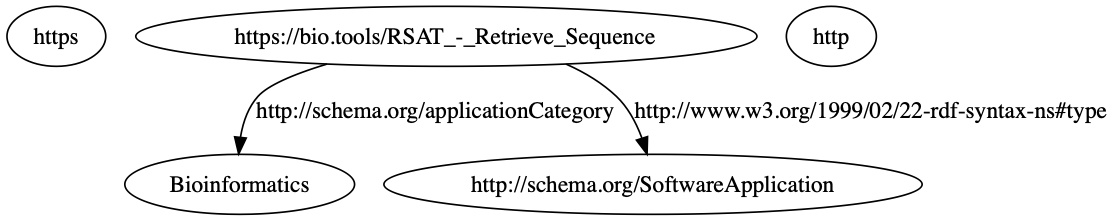

In [3]:
def vis_graph(rdf_graph):
    vis_query = """
        SELECT ?s ?p ?o WHERE {
            ?s ?p ?o .
        }
    """
    G = nx.DiGraph()
    G.graph['dpi'] = 120
    G.graph['layout'] = 'dot'

    results = rdf_graph.query(vis_query)
    for r in results :
        G.add_edge(r['s'], r['o'], label=r['p'])
        
    return G

draw(vis_graph(g), show='ipynb')
#nx.draw(vis_graph(g), with_labels = True)

# 2. How to compute BioSchema markup from Bio.Tools entries 
We proceed with the following steps to achieve this : 
  1. loading of the last available version of the Bio.Tools RDF data dump in an in-memory graph
  1. loading of last available version of the EDAM ontology in the same graph
  1. querying the graph to transform matched tools annotation into BioSchema 

Loading Bio.Tools content

In [4]:
biotools_graph = Graph().parse('https://raw.githubusercontent.com/bio-tools/biotoolsRdf/master/biotools-dump-latest.ttl', format='turtle')

Loading the EDAM ontology 

In [5]:
biotools_graph = biotools_graph.parse('http://edamontology.org/EDAM.owl', format='xml')
print("Size of the RDF graph: " + str(len(biotools_graph)) + " triples.")

Size of the RDF graph: 204438 triples.


A function to transform Bio.Tools RDF statements into BioSchema statements based on a `CONSTRUCT` SPARQL query.  

In [6]:
def get_bioschema_markup(biotools_id):
    bioschema_query = """
    
    CONSTRUCT {
        ?tool rdf:type <http://semanticscience.org/resource/SIO_000097> .
        ?tool rdf:type <http://schema.org/SoftwareApplication> .
        ?tool <http://schema.org/name> ?title . 
        ?tool <http://schema.org/description> ?desc . 
        ?tool <http://schema.org/featureList> ?op .
        ?tool <http://schema.org/keywords> ?topic_label .
    }  WHERE {
        BIND(URI(\"""" + biotools_id + """\") AS ?tool) .

        ?tool dc:title ?title .
        ?tool dc:description ?desc .
        ?tool biotools:has_function ?op .
        ?tool edam:has_topic ?topic .
        ?topic rdfs:label ?topic_label .
    }
"""
    results = biotools_graph.query(bioschema_query)
    newg = Graph().parse(data=results.serialize(format='xml'))
    
    return newg, newg.serialize(format='json-ld', context=context, indent=4).decode('utf-8')

We test this function with the [RSAT-Retrieve-Sequence](https://bio.tools/RSAT_-_Retrieve_Sequence) tool to generate its BioSchema markup. 

In [7]:
#bs_graph, markup  = get_bioschema_markup("https://bio.tools/signalp")
#bs_graph, markup  = get_bioschema_markup("https://bio.tools/jaspar")
bs_graph, markup  = get_bioschema_markup("https://bio.tools/RSAT_-_Retrieve_Sequence")
print(markup)

{
    "@context": "http://schema.org/",
    "description": "Starting from a list of genes, returns upstream or downstream sequences.",
    "featureList": "http://edamontology.org/operation_2422",
    "id": "https://bio.tools/RSAT_-_Retrieve_Sequence",
    "keywords": "Gene regulation",
    "name": "RSAT - Retrieve Sequence",
    "type": [
        "http://semanticscience.org/resource/SIO_000097",
        "SoftwareApplication"
    ]
}


We finally draw the new BioSchema / Schema.org graph. 

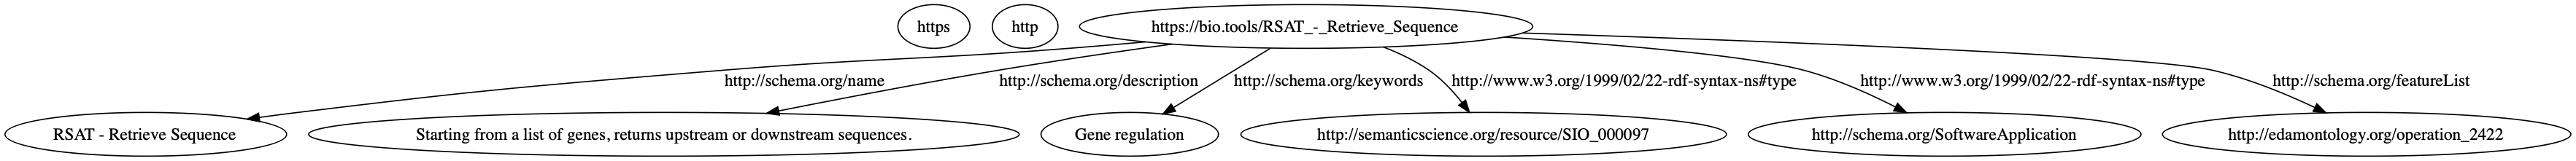

In [8]:
#nx.draw(vis_graph(newg), with_labels = True)
draw(vis_graph(bs_graph), show='ipynb')